In [1]:
import sys
sys.path.insert(1,'/home/thomas/research/projects/a549_40x/scripts/memes')
import warnings
warnings.filterwarnings("ignore")

import glob
import numpy as np
import pandas as pd
import pickle

from matplotlib import animation
from matplotlib import pyplot as plt

import os
from os import listdir


from skimage.measure import regionprops
from skimage.morphology import opening, closing, remove_small_holes, remove_small_objects,disk
from skimage.io import imread

from skimage.filters.rank import otsu
from traj_class import fluor_single_cell_traj
import matplotlib.animation as animation

from traj_tools import generate_single_cell_img,find_mother,find_mother_label,find_offspring,parse,count_num_fluor_pca_cord

In [2]:
def generate_fluor_intact_traj(df,cells,am_record,traj_df,traj,fluor_name,feature_list,fluor_feature_name):
    
    haralick_labels = ["Angular Second Moment",
                   "Contrast",
                   "Correlation",
                   "Sum of Squares: Variance",
                   "Inverse Difference Moment",
                   "Sum Average",
                   "Sum Variance",
                   "Sum Entropy",
                   "Entropy",
                   "Difference Variance",
                   "Difference Entropy",
                   "Information Measure of Correlation 1",
                   "Information Measure of Correlation 2",
                    "Maximal Correlation Coefficient"]
    
    
    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values
    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]
    
    traj_xy=[]
    traj_feature=[]
    traj_contour=[]
    traj_cord=[]
    traj_seri=[]
    traj_am_flag=[]
 
    traj_vim_feature_values=[]
    traj_vim_haralick=[]
    traj_vim_norm_haralick=[]
    traj_vim_pca_cord=[]
    
    traj_pcna_feature_values=[]
    traj_pcna_haralick=[]
    traj_pcna_norm_haralick=[]
    traj_pcna_pca_cord=[]

    for img_num in range(1,traj_len+1):
        obj_num=traj[img_num-1]
        if obj_num!=-1:
            ind=df.loc[(df['ImageNumber']==img_num)&(df['ObjectNumber']==obj_num)].index.tolist()[0]

            if hasattr(cells[ind],fluor_name[0]+'_feature_values') and \
                hasattr(cells[ind],fluor_name[1]+'_feature_values'):
                
                cell_pcna_feature_values = cells[ind].pcna_feature_values[3]
                num_zero_haralick = sum(x==0 for x in cell_pcna_feature_values)

                if num_zero_haralick != len(cell_pcna_feature_values):
                    if hasattr(cells[ind],'cell_contour') and hasattr(cells[ind],'pca_cord'):
                        traj_contour.append(cells[ind].cell_contour.points.flatten())
                        traj_cord.append(cells[ind].pca_cord)
                        traj_seri.append([img_num,obj_num])
                        traj_xy.append([df.loc[ind,'Cell_AreaShape_Center_X'],df.loc[ind,'Cell_AreaShape_Center_Y']])
                        traj_feature.append(df.loc[ind,'Cell_AreaShape_Area':'Cell_AreaShape_Solidity'].values.tolist())

                        if ((am_record['ImageNumber']==img_num)&(am_record['ObjectNumber']==obj_num)).any():
                            am_flag=np.asscalar(am_record.loc[(am_record['ImageNumber']==img_num)&\
                                (am_record['ObjectNumber']==obj_num),'am_flag'].values)
                            traj_am_flag.append(am_flag)
                        else:
                            traj_am_flag.append(0)

                        exec('traj_vim_feature_values.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[:3]))')
                        exec('traj_vim_haralick.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[3]))')
                        exec('traj_vim_norm_haralick.append(np.array(cells[ind].'+fluor_name[0]+'_feature_values[4]))')
                        exec('traj_vim_pca_cord.append(cells[ind].'+fluor_feature_name[0]+'_pca_cord)')

                        exec('traj_pcna_feature_values.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[:3]))')
                        exec('traj_pcna_haralick.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[3]))')
                        exec('traj_pcna_norm_haralick.append(np.array(cells[ind].'+fluor_name[1]+'_feature_values[4]))')
                        exec('traj_pcna_pca_cord.append(cells[ind].'+fluor_feature_name[1]+'_pca_cord)')
    
    traj_xy=np.asarray(traj_xy)
    traj_feature=np.asarray(traj_feature)
    traj_contour=np.asarray(traj_contour)
    traj_cord=np.asarray(traj_cord)
    traj_seri=np.asarray(traj_seri)
    
    traj_am_flag=np.asarray(traj_am_flag)
    
    traj_vim_feature_values=np.asarray(traj_vim_feature_values)
    traj_vim_haralick=np.asarray(traj_vim_haralick)
    traj_vim_norm_haralick=np.asarray(traj_vim_norm_haralick)
    traj_vim_pca_cord=np.asarray(traj_vim_pca_cord)  
    
    traj_pcna_feature_values=np.asarray(traj_pcna_feature_values)
    traj_pcna_haralick=np.asarray(traj_pcna_haralick)
    traj_pcna_norm_haralick=np.asarray(traj_pcna_norm_haralick)
    traj_pcna_pca_cord=np.asarray(traj_pcna_pca_cord)  
   
#     mask=traj_fluor_feature_values[:,0]!=0
    
        
#     abn_inds=find_abnormal_fluor(traj_vim_feature_values[:,0],traj_seri[:,0])
#     if len(abn_inds)>0:
#         traj_vim_feature_values[abn_inds,:]=0
#         traj_vim_haralick[abn_inds,:]=0
#         traj_vim_norm_haralick[abn_inds,:]=0
#         print(traj_vim_pca_cord.shape)
#         traj_vim_pca_cord[abn_inds,:]=0
    if len(traj_pcna_feature_values) > 0:
        return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
               [traj_vim_feature_values[:,0],traj_vim_feature_values[:,1],traj_vim_feature_values[:,2],\
               traj_vim_haralick,traj_vim_norm_haralick],traj_vim_pca_cord,\
               [traj_pcna_feature_values[:,0],traj_pcna_feature_values[:,1],traj_pcna_feature_values[:,2],\
               traj_pcna_haralick,traj_pcna_norm_haralick],traj_pcna_pca_cord
    else:
        return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
               traj_vim_feature_values,traj_vim_pca_cord,\
               traj_pcna_feature_values,traj_pcna_pca_cord


In [3]:
# lock & load
main_path='/home/thomas/research/projects/a549_40x/data/'
ori_path=main_path+'ori/pcna/01-13-22_72hr_no-treat/'
output_path=main_path+'out/pcna/01-13-22_72hr_no-treat/'
sct_path=output_path+'traj/ict-02/'
cell_ani_path=output_path+'traj/intact-cell_ani/'
cell_nuc_ani_path=output_path+'traj/intact-nuc_ani/'
if not os.path.exists(sct_path):
    os.makedirs(sct_path)
if not os.path.exists(cell_ani_path):
    os.makedirs(cell_ani_path)
if not os.path.exists(cell_nuc_ani_path):
    os.makedirs(cell_nuc_ani_path)



# parameters
time_span=865
traj_len_thres=288

feature_list=['mean_intensity','std_intensity','intensity_range','haralick','norm_haralick']
fluor_feature_name=['vimentin_haralick','pcna_haralick']

In [4]:
traj_df=pd.read_csv(output_path+'traj_object_num-intact.csv')

traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
traj_record=traj_record.values
traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]

traj_record_posi=traj_df.loc[:,'position']
traj_record_label=traj_df.loc[:,'traj_label']

        traj length threshold approved
        traj length threshold approved
            traj length seri len satisfactory
            ict_XY1_290 - traj_leng = 80
        traj length threshold approved
            traj length seri len satisfactory
            ict_XY1_175 - traj_leng = 57
        traj length threshold approved
            traj length seri len satisfactory
            ict_XY2_98 - traj_leng = 60
        traj length threshold approved
        traj length threshold approved
            traj length seri len satisfactory
            ict_XY2_153 - traj_leng = 56
        traj length threshold approved
            traj length seri len satisfactory
            ict_XY2_180 - traj_leng = 72
        traj length threshold approved
            traj length seri len satisfactory
            ict_XY2_179 - traj_leng = 60
        traj length threshold approved
            traj length seri len satisfactory
            ict_XY2_196 - traj_leng = 53
        traj length threshold approved


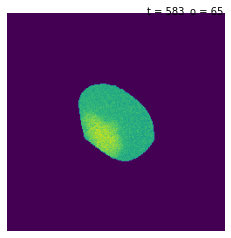

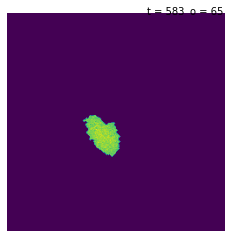

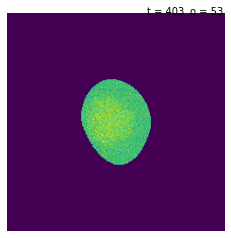

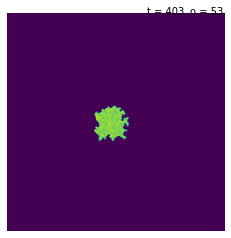

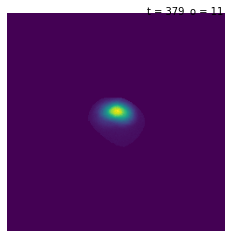

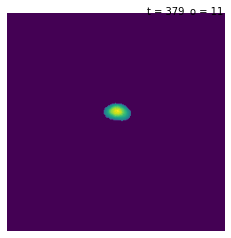

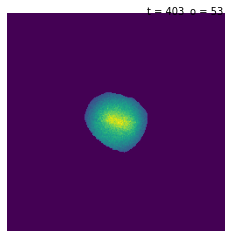

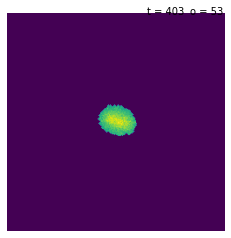

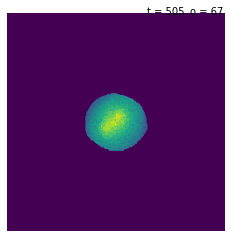

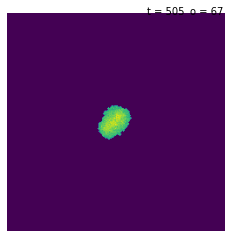

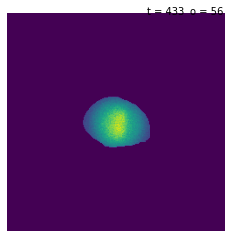

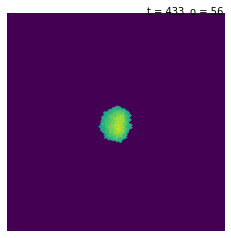

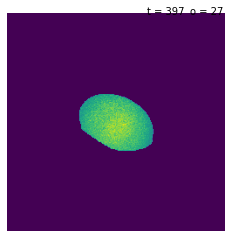

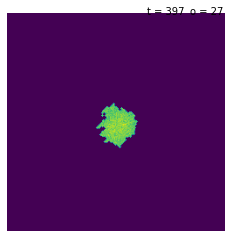

In [7]:
for traj_idx in range(len(traj_df)):
    
    posi_label = 'XY' + str(traj_record_posi[traj_idx])
    traj_label=traj_record_label[traj_idx]

    dir_path=output_path+posi_label+'/'
    cells_path=dir_path+'cells/'
    seg_path=output_path+posi_label+'/seg/'

    fluor_img_list=sorted(glob.glob(ori_path+posi_label+'_C2/*C2*'))
    seg_list=sorted(glob.glob(seg_path+'*'))
    df=pd.read_csv(dir_path+'Per_Object_relink.csv')
    am_record=pd.read_csv(dir_path+'am_record.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record.csv')
    with open (cells_path+'pcna_cells-02', 'rb') as fp:
        cells = pickle.load(fp)
        # print('now processing trajectory ' + str(traj_label))

    cur_traj=traj_record[traj_idx,:]
    
    traj_start_t=np.where(cur_traj!=-1)[0][0]+1
    traj_end_t=np.where(cur_traj!=-1)[0][-1]+1

    if (traj_end_t-traj_start_t)>=traj_len_thres:

        print('        traj length threshold approved')
        traj_name=str(traj_label)

        traj_feature,traj_contour,\
            traj_cord,traj_seri,traj_am_flag,\
            traj_vim_feature_values,traj_vim_pca_cord,\
            traj_pcna_feature_values,traj_pcna_pca_cord=generate_fluor_intact_traj(
            df,cells,am_record,\
            traj_df,cur_traj,\
            ['vimentin','pcna'],feature_list,fluor_feature_name)

        if len(traj_seri) >= 18:
            print('            traj length seri len satisfactory')
            traj_sct=fluor_single_cell_traj(traj_seri,traj_contour)
            traj_sct.set_traj_feature(traj_feature)
            traj_sct.set_traj_cord(traj_cord)
            traj_sct.set_traj_am_flag(traj_am_flag)

            traj_sct.set_traj_fluor_features('vimentin',feature_list,traj_vim_feature_values)
            traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[0],traj_vim_pca_cord)

            traj_sct.set_traj_fluor_features('pcna',feature_list,traj_pcna_feature_values)
            traj_sct.set_traj_fluor_pca_cord(fluor_feature_name[1],traj_pcna_pca_cord)
            
            print('            ict_'+posi_label+'_'+traj_name+' - traj_leng = '+str(len(traj_seri)))
            with open(sct_path+'ict_'+posi_label+'_'+traj_name+'-011322', 'wb') as fp:
                pickle.dump(traj_sct, fp)

            board_size=250

            fig=plt.figure()
            ax = fig.add_subplot(111)
            ims=[]
            for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:
                img_num=img_num.astype(np.int)
                obj_num=obj_num.astype(np.int)
                if obj_num!=-1:
                    img=imread(fluor_img_list[img_num-1])
                    seg_img=imread(seg_list[img_num-1])
                    crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
                    x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
                    x_l,y_l=board_size//2-x_c,board_size//2-y_c
                    cell_on_board=np.zeros((board_size,board_size))
                    cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell
                    plt.axis('off')
                    im=plt.imshow(cell_on_board,animated=True)
                    t = ax.annotate('t = ' + str(img_num),(160,1))
                    o = ax.annotate('o = ' + str(obj_num),(210,1))
                    ims.append([im,t,o])

            ani = animation.ArtistAnimation(fig, ims)
            video_writer = animation.FFMpegWriter(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
            ani.save(cell_ani_path+'sub_pcna_'+posi_label+'_'+traj_name+'.mp4',video_writer)

            fig=plt.figure()
            ax = fig.add_subplot(111)
            ims=[]
            for img_num,obj_num in traj_seri[traj_pcna_feature_values[0]>0]:

                img_num=img_num.astype(np.int)
                obj_num=obj_num.astype(np.int)

                img=imread(fluor_img_list[img_num-1])
                seg=imread(seg_list[img_num-1])

                if obj_num!=-1:

                    rps=regionprops(seg)
                    candi_r=[r for r in rps if r.label==obj_num][0]
                    candi_box=candi_r.bbox

                    cell_mask = (seg == obj_num)
                    region_cell_mask = cell_mask[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                    crop_img = img[candi_box[0]:candi_box[2], candi_box[1]:candi_box[3]]
                    cell_img = (img*cell_mask)[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]

                    nuc_mask=cell_img>otsu(cell_img,selem=disk(max(cell_img.shape)/2), mask=cell_img>0)
                    nuc_mask=remove_small_objects(opening(nuc_mask),100)
                    nuc_mask=closing(nuc_mask)
                    nuc_mask=remove_small_holes(nuc_mask,100)

                    nuc_img=cell_img*nuc_mask

                    x_c,y_c=nuc_img.shape[0]//2,nuc_img.shape[1]//2
                    x_l,y_l=board_size//2-x_c,board_size//2-y_c
                    cell_on_board=np.zeros((board_size,board_size))
                    cell_on_board[x_l:x_l+nuc_img.shape[0],y_l:y_l+nuc_img.shape[1]]=nuc_img
                    plt.axis('off')
                    im=plt.imshow(cell_on_board,animated=True)
                    t = ax.annotate('t = ' + str(img_num),(160,1))
                    o = ax.annotate('o = ' + str(obj_num),(210,1))
                    ims.append([im,t,o])

            ani = animation.ArtistAnimation(fig, ims)
            video_writer = animation.FFMpegWriter(fps=3, metadata=dict(artist='Thomas'), bitrate=-1)
            ani.save(cell_nuc_ani_path+'sub_pcna_'+posi_label+'_'+traj_name+'.mp4',video_writer)